# HMM

### Import package

In [1]:
from matplotlib import rcParams
import warnings
#from sklearn import mixture
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
#import sklearn.mixture as mix
from pmdarima import model_selection
import yfinance as yf
import ta
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.preprocessing import StandardScaler
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import datetime


rcParams['figure.figsize'] = [20, 10]
warnings.filterwarnings("ignore")
%matplotlib inline

D:\Anaconda3\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


### Define functions

In [2]:
def bull_bear_staic_eval(df, bull = [], bear = [], static = []):
    cumulative_return = [1]
    for dr, state in zip(df['1_week_return'], df['new_state']):
        re = dr
        if state in bear:
            re = -re
        elif state in static:
            re = 0.003/52
        cumulative_return.append(cumulative_return[-1]*(1+re))
    return cumulative_return

In [3]:
def bic_general(likelihood_fn, k, X):
    """likelihood_fn: Function. Should take as input X and give out   the log likelihood
                  of the data under the fitted model.
           k - int. Number of parameters in the model. The parameter that we are trying to optimize.
                    For HMM it is number of states.
                    For GMM the number of components.
           X - array. Data that been fitted upon.
    """
    bic = np.log(len(X))*k - 2*likelihood_fn(X)
    return bic
def aic_general(likelihood_fn, k, X):
    """likelihood_fn: Function. Should take as input X and give out   the log likelihood
                  of the data under the fitted model.
           k - int. Number of parameters in the model. The parameter that we are trying to optimize.
                    For HMM it is number of states.
                    For GMM the number of components.
           X - array. Data that been fitted upon.
    """
    aic = 2*k - 2*likelihood_fn(X)
    return aic

def bic_hmmlearn(X):
    lowest_bic = np.infty
    aic = []
    bic = []
    n_states_range = range(1,9)
    for n_components in n_states_range:
        hmm_curr = hmm.GMMHMM(n_components=n_components, covariance_type="full")
        hmm_curr.fit(X)

        # Calculate number of free parameters
        # free_parameters = for_means + for_covars + for_transmat + for_startprob
        # for_means & for_covars = n_features*n_components
        n_features = hmm_curr.n_features
        free_parameters = 2*(n_components*n_features) + n_components*(n_components-1) + (n_components-1)
        
        aic_curr = aic_general(hmm_curr.score, free_parameters, X)
        aic.append(aic_curr)
        bic_curr = bic_general(hmm_curr.score, free_parameters, X)
        bic.append(bic_curr)
    #plt.plot(n_states_range, aic, label = "aic")
    plt.plot(n_states_range, bic, label = "bic")
    plt.legend()
    plt.show()

In [4]:
def plot_candlestick(df):
    df = df.reset_index()
    ohlc = df.loc[:, ['Date','Open', 'High', 'Low', 'Close']]
    ohlc['Date']=ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    fig, ax = plt.subplots(figsize=(10,5))

    candlestick_ohlc(ax, ohlc.values, width=4, colorup='green', colordown='red', alpha=1)

    # Setting labels & titles
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    fig.suptitle('Weekly Candlestick Chart of Russell3000')

    # Formatting Date
    date_format = mpl_dates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    bull = df.loc[df["new_state"] == 1 , 'Date']
    for day in bull:
        plt.axvspan(day, day + datetime.timedelta(weeks=1), color="green", alpha=0.15)
    static = df.loc[df["new_state"] == 0 , 'Date']
    for day in static:
        plt.axvspan(day, day + datetime.timedelta(weeks=1), color="blue", alpha=0.15)
    bear = df.loc[df["new_state"] == -1 , 'Date']
    for day in bear:
        plt.axvspan(day, day + datetime.timedelta(weeks=1), color="red", alpha=0.15)

In [5]:
def combine_state(df, bull=[], bear=[], static=[]):
    df['new_state'] = df['state'].apply(lambda x: 1 if x in bull else (-1 if x in bear else 0))
    return df

### Load data 

In [6]:
import yfinance as yf

russell = yf.download("^RUA",interval='1wk')
russell

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1987-09-07,178.960007,181.470001,177.050003,181.339996,181.339996,0
1987-09-14,181.339996,182.250000,177.199997,177.690002,177.690002,0
1987-09-21,177.690002,181.009995,174.649994,180.229996,180.229996,0
1987-09-28,180.229996,184.949997,180.229996,184.699997,184.699997,0
1987-10-05,184.710007,184.940002,176.029999,176.070007,176.070007,0
...,...,...,...,...,...,...
2022-03-14,2445.139893,2599.500000,2415.149902,2598.199951,2598.199951,0
2022-03-21,2597.310059,2639.239990,2573.159912,2637.370117,2637.370117,0
2022-03-28,2637.370117,2697.919922,2620.800049,2643.199951,2643.199951,0


In [7]:
mom_data = add_all_ta_features(russell.copy(), open="Open", high="High", low="Low", close="Close", volume="Volume")
mom_data['1_week_return'] = mom_data['Close'].pct_change()
mom_data['4_week_return'] = mom_data['Close'].pct_change(periods=4)
mom_data['12_week_return'] = mom_data['Close'].pct_change(periods=12)
mom_data['trend_sma_diff'] = mom_data['Close'].rolling(5).mean().pct_change()

In [8]:
features = pd.read_csv('features.csv')
features['Date'] = pd.to_datetime(features['Date']).apply(pd.DateOffset(-4))
features = features.set_index('Date')

In [9]:
mom_data['vix_index'] = features['VIX Index']
mom_data['ray_index_50'] = features['RAY Index - Percentage of Members with Px > 50 Day Moving Avg']

In [10]:
indicators = ['momentum_rsi','trend_cci','trend_mass_index','4_week_return','12_week_return','volatility_dcw']
#indicators = ['momentum_rsi','trend_cci','trend_mass_index','volatility_dcw','trend_sma_diff']
#indicators = indicators + ['ray_index_50']

In [11]:
train = mom_data[(mom_data.index.year >= 1998) &(mom_data.index.year < 2013)]
test = mom_data[(mom_data.index.year >= 2013)&(mom_data.index.year < 2018)]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
transformed_data = sc.fit_transform(train[indicators])
transformed_data = pd.DataFrame(transformed_data,index=train.index,columns=indicators)
transformed_data

,momentum_rsi,trend_cci,trend_mass_index,4_week_return,12_week_return,volatility_dcw
Date,,,,,,
1998-01-05,-0.316750,-0.303318,1.216241,-0.558945,-0.422084,-0.488592
1998-01-12,0.194025,-0.358181,1.277061,0.192698,0.006139,-0.492866
1998-01-19,0.130580,0.312588,1.279091,0.288122,0.320423,-0.494765
1998-01-26,0.437688,-0.274946,1.410680,-0.044681,0.421886,-0.498321
1998-02-02,0.860603,1.839629,1.427198,1.632047,0.855550,-0.241549
...,...,...,...,...,...,...
2012-12-03,0.096244,-0.124297,-0.379478,0.492264,-0.494836,-0.777299
2012-12-10,0.026041,0.042818,-0.462132,0.748932,-0.459176,-0.917700
2012-12-17,0.335747,0.295600,-0.554314,0.300748,-0.141067,-0.919633


### Plot BIC

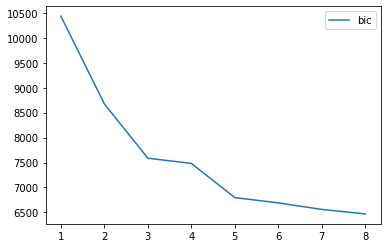

In [12]:
bic_hmmlearn(transformed_data)

### Training

In [13]:
HMM = hmm.GaussianHMM(n_components=6, covariance_type="full")
HMM.fit(transformed_data)#transformed_data
hidden_states = HMM.predict(transformed_data)#transformed_data
states = pd.DataFrame(hidden_states,index=train.index)
data_with_state = pd.concat([train[indicators+['Open', 'High', 'Low', 'Close','1_week_return']],states],axis=1,sort='False').dropna()
data_with_state.rename(columns={0:'state'}, inplace=True)
data_with_state

,momentum_rsi,trend_cci,trend_mass_index,4_week_return,12_week_return,volatility_dcw,Open,High,Low,Close,1_week_return,state
Date,,,,,,,,,,,,
1998-01-05,49.977854,-10.685804,26.659479,-0.025085,-0.025433,13.251013,544.479980,548.489990,514.869995,517.679993,-0.049221,0
1998-01-12,55.794312,-16.696552,26.743245,0.013700,0.011403,13.212305,517.679993,537.429993,509.190002,535.719971,0.034848,0
1998-01-19,55.071833,56.792819,26.746042,0.018623,0.038438,13.195110,535.719971,544.729980,530.760010,533.830017,-0.003528,0
1998-01-26,58.569033,-7.577333,26.927275,0.001451,0.047166,13.162906,533.830017,551.080017,494.339996,545.270020,0.021430,0
1998-02-02,63.384991,224.095190,26.950025,0.087969,0.084471,15.488280,545.270020,563.950012,545.270020,563.219971,0.032919,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-03,54.680833,8.927669,24.461741,0.029157,-0.031692,10.636427,839.960022,842.219971,827.849976,839.010010,0.001408,2
2012-12-10,53.881396,27.236867,24.347903,0.042401,-0.028624,9.364932,838.070007,851.159973,835.880005,836.849976,-0.002575,2
2012-12-17,57.408184,54.931546,24.220944,0.019275,-0.001260,9.347424,837.200012,857.349976,837.200012,848.210022,0.013575,2


<AxesSubplot:xlabel='Date', ylabel='Close'>

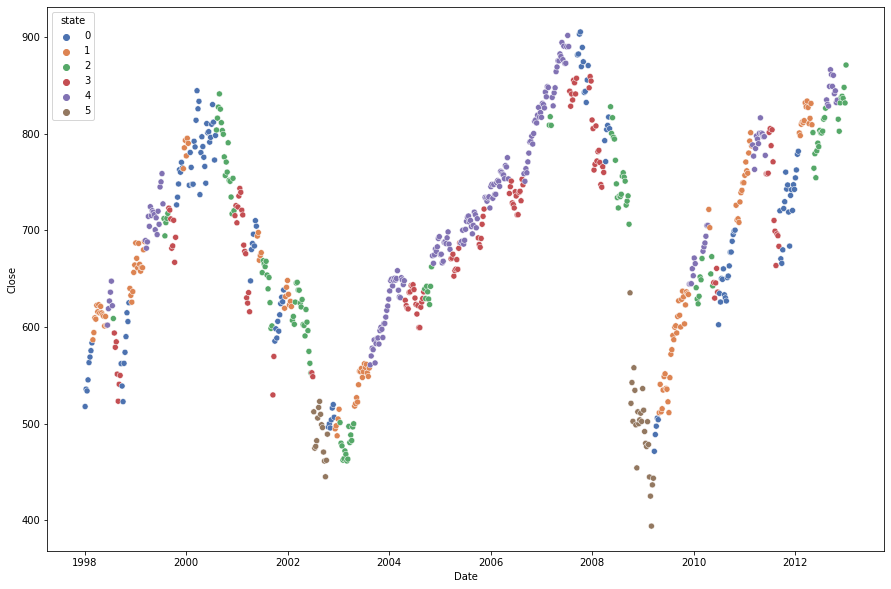

In [14]:
# Plotting the time series using a scatterplot, with observations coloured by hidden state.
fig, ax = plt.subplots(1,1,figsize=(15, 10))
sns.scatterplot(x='Date', y='Close', data=data_with_state, hue='state', palette="deep")

In [15]:
for i in range(6):
    print(f'{i}:')
    print(data_with_state.loc[data_with_state['state'] == i].describe()['4_week_return']['mean'])
    print(data_with_state.loc[data_with_state['state'] == i].describe()['4_week_return']['std'])

0:
0.032273955812424426
0.054724505739986905
1:
0.02135099736221625
0.03457470924116459
2:
-0.015230022810383718
0.0410424122236704
3:
-0.02535897235582063
0.04766161052333085
4:
0.017188148170864437
0.022721572192896073
5:
-0.06376506524487874
0.09621954138804392


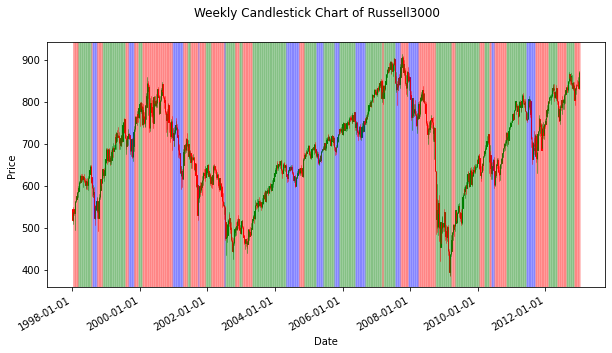

In [16]:
data_with_state = combine_state(data_with_state, bull = [1,4,5], bear = [2,0], static = [3])
plot_candlestick(data_with_state)

### Testing

In [17]:
transformed_test_data = sc.transform(test[indicators])
transformed_test_data = pd.DataFrame(transformed_test_data,index=test.index,columns=indicators)
transformed_test_data

,momentum_rsi,trend_cci,trend_mass_index,4_week_return,12_week_return,volatility_dcw
Date,,,,,,
2013-01-07,0.795147,1.202678,-0.448888,0.807214,0.289222,-0.873537
2013-01-14,0.966851,1.340180,-0.512944,0.738308,0.588374,-0.765536
2013-01-21,1.172769,1.493885,-0.587109,1.388911,0.706210,-0.622635
2013-01-28,1.275594,1.484280,-0.625088,0.577069,1.090773,-0.541619
2013-02-04,1.335685,1.282087,-0.636565,0.570727,1.337395,-0.512332
...,...,...,...,...,...,...
2017-11-27,2.335652,1.088658,-0.329208,0.352295,0.757323,-0.854177
2017-12-04,2.379495,1.032849,-0.199782,0.458424,0.581474,-0.819036
2017-12-11,2.532551,1.044176,-0.114577,0.608777,0.651418,-0.791131


In [18]:
hidden_states = HMM.predict(transformed_test_data)
states = pd.DataFrame(hidden_states,index=test.index)
test_data_with_state = pd.concat([test[indicators+['Open', 'High', 'Low', 'Close','1_week_return']],states],axis=1,sort='False').dropna()
test_data_with_state.rename(columns={0:'state'}, inplace=True)
test_data_with_state

,momentum_rsi,trend_cci,trend_mass_index,4_week_return,12_week_return,volatility_dcw,Open,High,Low,Close,1_week_return,state
Date,,,,,,,,,,,,
2013-01-07,62.639615,154.310935,24.366144,0.045408,0.035754,9.764876,870.210022,875.169983,862.880005,874.849976,0.003982,0
2013-01-14,64.594895,169.375624,24.277922,0.041853,0.061488,10.742955,874.840027,883.710022,870.349976,883.710022,0.010128,4
2013-01-21,66.939799,186.215528,24.175775,0.075424,0.071624,12.037099,883.690002,894.929993,881.250000,894.859985,0.012617,4
2013-01-28,68.110717,185.163179,24.123469,0.033533,0.104705,12.770795,895.059998,901.369995,890.510010,900.599976,0.006414,4
2013-02-04,68.795005,163.010931,24.107661,0.033206,0.125920,13.036017,898.200012,903.900024,889.849976,903.900024,0.003664,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27,80.182171,141.818959,24.530975,0.021935,0.076021,9.940203,1543.500000,1575.079956,1541.109985,1565.880005,0.014335,1
2017-12-04,80.681435,135.704509,24.709231,0.027411,0.060894,10.258453,1568.689941,1580.369995,1553.640015,1569.359985,0.002222,1
2017-12-11,82.424361,136.945514,24.826581,0.035169,0.066911,10.511165,1569.719971,1584.780029,1567.260010,1582.079956,0.008105,1


<AxesSubplot:xlabel='Date', ylabel='Close'>

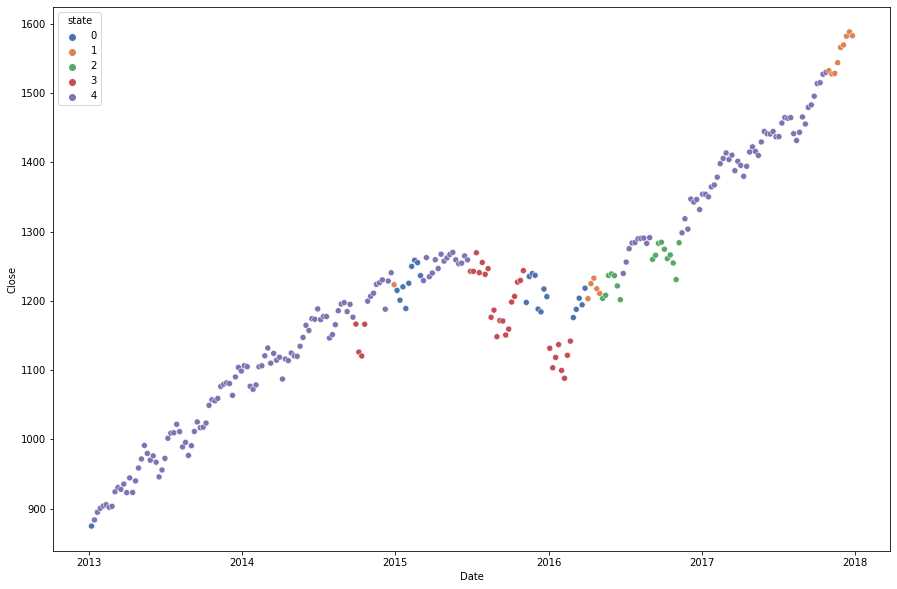

In [19]:
# Plotting the time series using a scatterplot, with observations coloured by hidden state.
fig, ax = plt.subplots(1,1,figsize=(15, 10))
sns.scatterplot(x='Date', y='Close', data=test_data_with_state, hue='state', palette="deep")

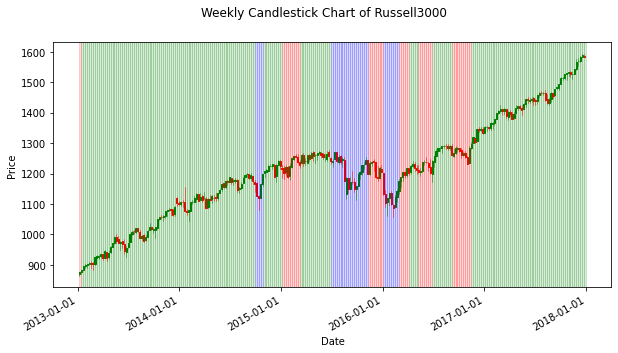

In [20]:
test_data_with_state = combine_state(test_data_with_state, bull = [1,4,5], bear = [2,0], static = [3])
plot_candlestick(test_data_with_state)